# Problem statement

## Project goal
The life insurance policy documents are very elaborate and lengthy. It's a challenge to go through the entire document at once and understand it well.
This project provides an easy way to understand the document by asking asking questions and queries to the RAG based application.

# Solution Architecture

## Architecture diagram

![architecture.drawio.png](./architecture.drawio.png)
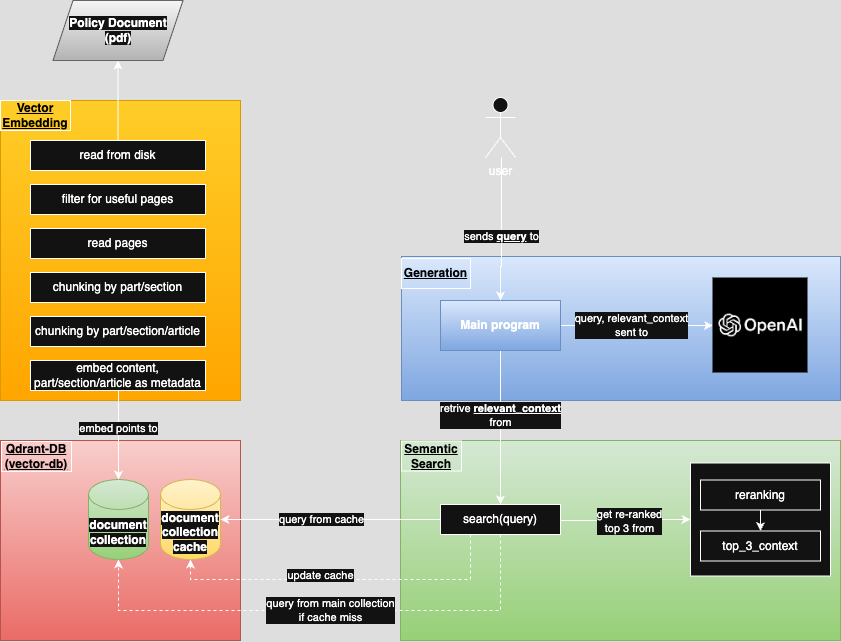

## Architecture description & Design choices

### Vector Embedding Pipeline

1. **Read from disk**  
   Load the PDF policy document.

2. **Filter useful pages**  
   Retain only pages with meaningful content (those which are within a part and section).

3. **Read pages**  
   Extract text content using a PDF parser (using `pdfplumber`).

4. **Chunk by part/section**  
   Split document hierarchically to maintain structure.

5. **Chunk by part/section/article**  
   Finer-level segmentation for better retrieval precision.

6. **Embed content**  
   Use sentence embedding model (`all-MiniLM-L6-v2`).

7. **Add metadata**  
   Attach `part`, `section`, and `article` as payload.

---

### Qdrant Vector DB

8. **Create `document collection`**  
   Stores all document chunks with embeddings and metadata.

9. **Create `document collection cache`**  
   Stores previously seen query results for reuse.

10. **Embed points**  
    Vectorized chunks are inserted into the main collection.

---

### Semantic Search & Caching

11. **`search(query)`**
    - Checks `cache` collection first.
    - If found → return cached result.
    - If not → search main `document collection`.

12. **Update cache**  
    Stores new query + result in cache for future reuse.

13. **Retrieve `relevant_context`**  
    Search result passed back to main app for response generation.

---

### Re-ranking

14. **Re-rank results**  
    Use a cross-encoder (e.g., `ms-marco-MiniLM`) to refine ranking.

15. **Select top 3**  
    Final `top_3_context` chosen for LLM prompt.


---

### Main Program Flow

16. **User sends query**  
    A natural language question is submitted.

17. **Main program dispatches search**  
    Sends query to semantic search module.

18. **Send to OpenAI**  
    Passes `query` + `relevant_context` to OpenAI for generation.

---


## Solution Implementation

### Imports

In [1]:
from IPython.display import JSON
import pdfplumber
from sentence_transformers import SentenceTransformer, CrossEncoder
from qdrant_client import QdrantClient
from hashlib import sha256
import pandas as pd
import openai
import json


### Embedding Layer

#### Text Processing

In [2]:
pdf_document_file_path = "./Life Insurance Policy Sample.pdf"

def is_useful_page(text):
    return "Section" in text.strip().splitlines()[-1]

def get_part(text):
    return text.strip().splitlines()[-2]

def get_section(text):
    last_line = text.strip().splitlines()[-1]
    section_with_page_number = "Section " + last_line.split("Section")[1]
    return section_with_page_number.split("Page")[0].strip().split(",")[0].strip()

def process_document(document_path):
    data = {}

    with pdfplumber.open(document_path) as pdf:
        for page in pdf.pages:
            full_text = page.extract_text()
            if is_useful_page(full_text):
                part                = get_part(full_text)
                section             = get_section(full_text)
    
                if part not in data:
                    data[part] = {}
                data_part = data[part]
    
                if section not in data_part:
                    data_part[section] = []
                data_part_section = data_part[section]
    
                data_part_section.extend(full_text.splitlines())
    return data

# JSON(process_document(pdf_document_file_path))

#### Chunking

In [3]:
def is_not_same(left, right):
    return left.replace(" ", "").lower() not in right.replace(" ", "").lower()

def get_chunks(data):
    documents = []
    for part,part_detail in data.items():
        for section, section_detail in part_detail.items():
            article = ""
            article.replace(" ", "").lower()
            content = ""
            for line in section_detail:
                if is_not_same(part, line) and is_not_same(section, line) and is_not_same("This policy has been updated effective", line):
                    if "Article " in line and " - " in line:
                        if article and content:
                            documents.append({
                                "part": part,
                                "section": section,
                                "article": article,
                                "content": content
                            })
                        article = line
                        content = ""
                        continue
                    else:
                        content += line + " "
                else:
                    continue
    
            # Append the last article and content
            if article and content:
                documents.append({
                    "part": part,
                    "section": section,
                    "article": article,
                    "content": content
                })
    return documents

#### Embedding Logic

In [4]:
sentence_embedding_model_name = "all-MiniLM-L6-v2"
sentence_embedding_model = SentenceTransformer(sentence_embedding_model_name)

def get_embeddable_points(chunks):
    points = [{
        "id" : i,
        "vector": sentence_embedding_model.encode(chunk["content"]),
        "payload": {
            "part": chunk["part"],
            "section": chunk["section"],
            "article": chunk["article"],
            "content": chunk["content"],
            "text_length": len(chunk["content"])
        }
    } for i,chunk in enumerate(chunks)]
    return points

#### Prepare Vector DB

In [5]:
client = QdrantClient(
    host = 'localhost',
    port = 6333
)

client.delete_collection(
    collection_name = "life_insurance_policy_documents"
)

client.create_collection(
    collection_name = "life_insurance_policy_documents",
    vectors_config = {
            "size": 384,
            "distance": "Cosine"
    }
)

client.delete_collection(
    collection_name = "life_insurance_policy_documents_cache"
)
client.create_collection(
    collection_name = "life_insurance_policy_documents_cache",
    vectors_config = {
            "size": 384,
            "distance": "Cosine"
    }
)

True

##### output

![empty_collections.png](./empty_collections.png)
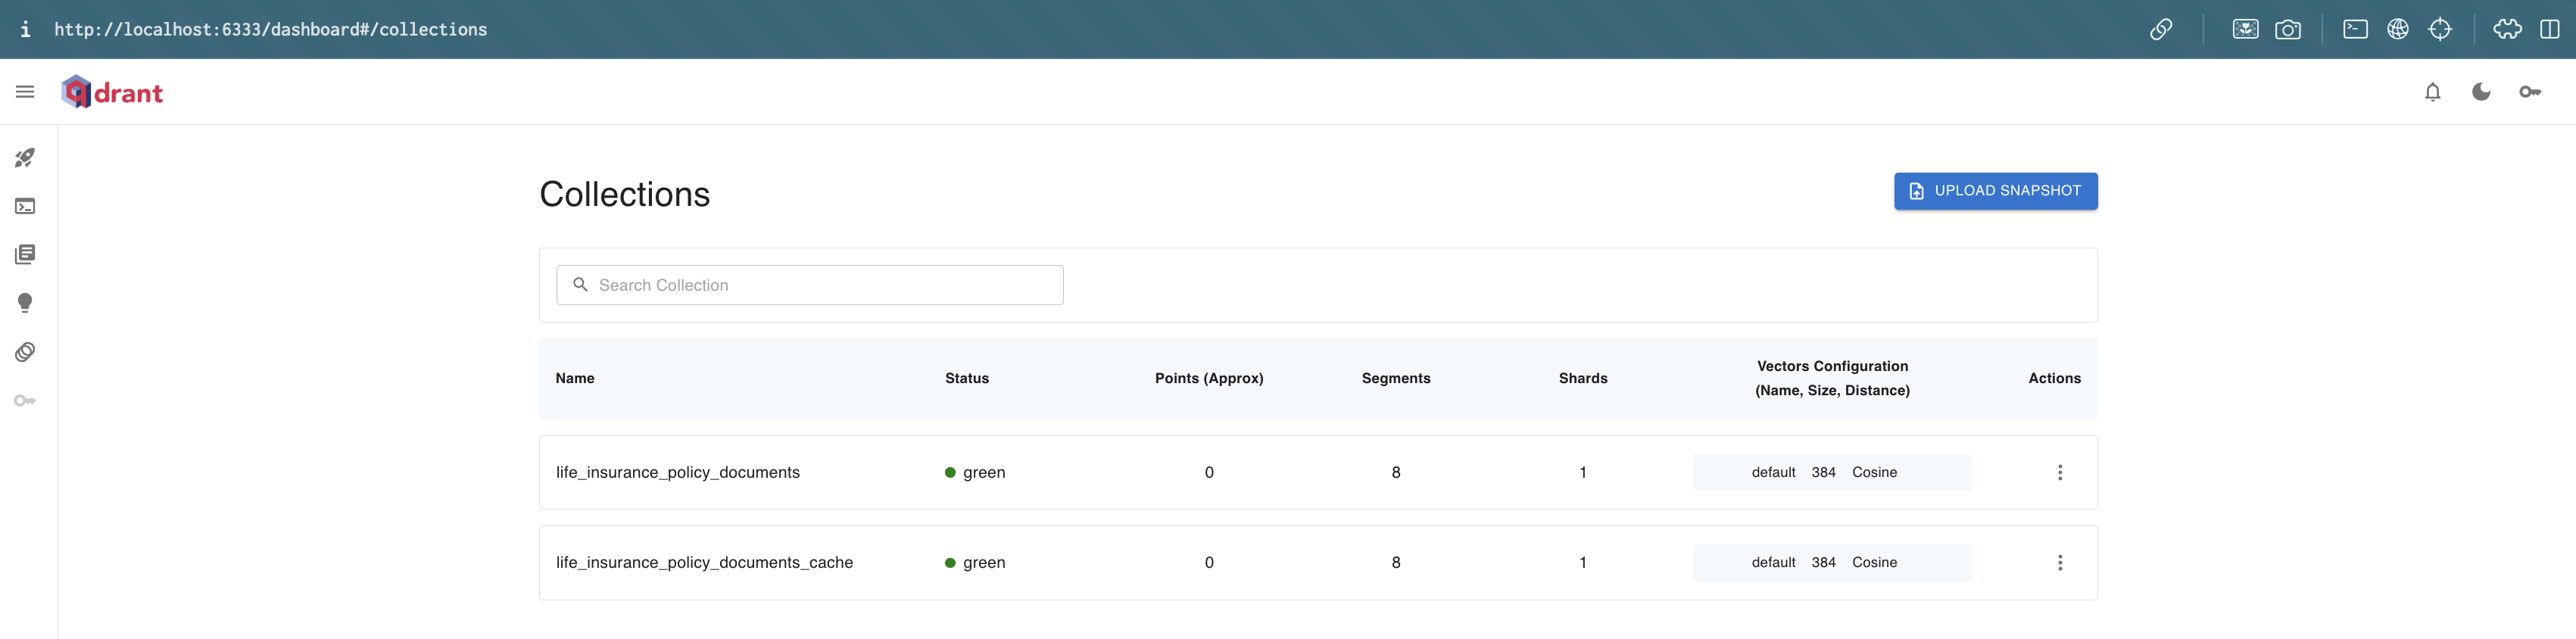

#### Embedding the chunks

In [6]:
part_section_data = process_document(pdf_document_file_path)
chunks = get_chunks(part_section_data)
embeddable_points = get_embeddable_points(chunks)

client.upsert(
    collection_name = "life_insurance_policy_documents",
    points = embeddable_points
)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

##### output

![filled_collection.png](filled_collection.png)
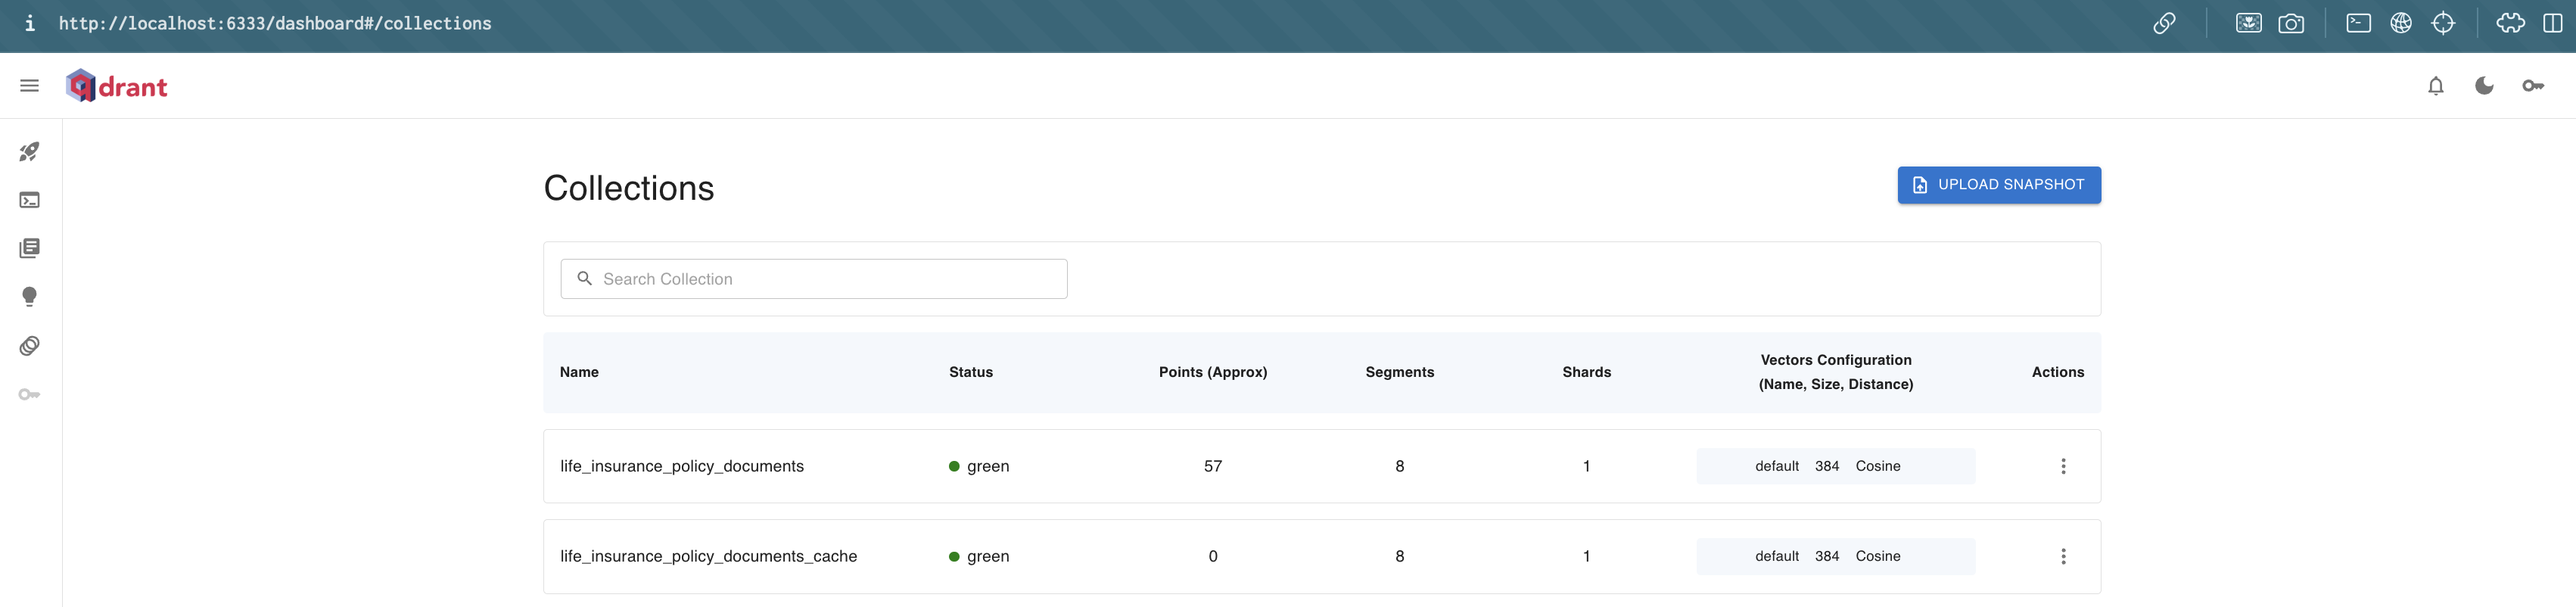

### Search Layer

#### Search & Cache

In [7]:
def hash_query(query: str) -> str:
    return sha256(query.encode()).hexdigest()

def save_to_cache(query: str, points: list) -> None:
    query_embedding = sentence_embedding_model.encode(query)
    query_hash = hash_query(query)
    client.upsert(
        collection_name = "life_insurance_policy_documents_cache",
        points = [{
            "id": int(query_hash[:16], 16),
            "vector": query_embedding,
            "payload": {
                "query": query,
                "query_hash": query_hash,
                "points": points
            }
        }]
    )

def query_cache_collection(query: str, limit=5) -> list:
    query_hash = hash_query(query)
    query_response = client.query_points(
        collection_name = "life_insurance_policy_documents_cache",
        query_filter = {
            "must" : [
                {"key": "query_hash", "match": {"value": query_hash}},
            ]
        },
        limit = limit,
        with_payload = True
    )
    points = []
    if len(query_response.points) > 0:
        points = query_response.points[0].payload['points']
    return points

def query_collection(query: str, limit=5) -> list:
    query_response = client.query_points(
        collection_name = "life_insurance_policy_documents",
        query = sentence_embedding_model.encode(query),
        limit = limit,
        with_payload = True
    )
    results = []
    [results.append({
        "id" : point.id,
        "version": point.version,
        "score": point.score,
        "part": point.payload["part"],
        "section": point.payload["section"],
        "article": point.payload["article"],
        "content": point.payload["content"],
        "text_length": point.payload["text_length"]
    }) for point in query_response.points]
    return results

def search(query: str, limit=3) -> list:
    points = query_cache_collection(query, limit)
    if len(points) == 0:
        points = query_collection(query, limit)
        save_to_cache(query, points)
        print("Cache miss!")
    else:
        print("Cache hit!")
    return points

##### search test

In [8]:
JSON(search("who has the authority to change the policy?"))

Cache miss!


<IPython.core.display.JSON object>

##### cache test

In [9]:
JSON(search("who has the authority to change the policy?"))

Cache hit!


<IPython.core.display.JSON object>

###### output

![cache_test_output.png](cache_test_output.png)
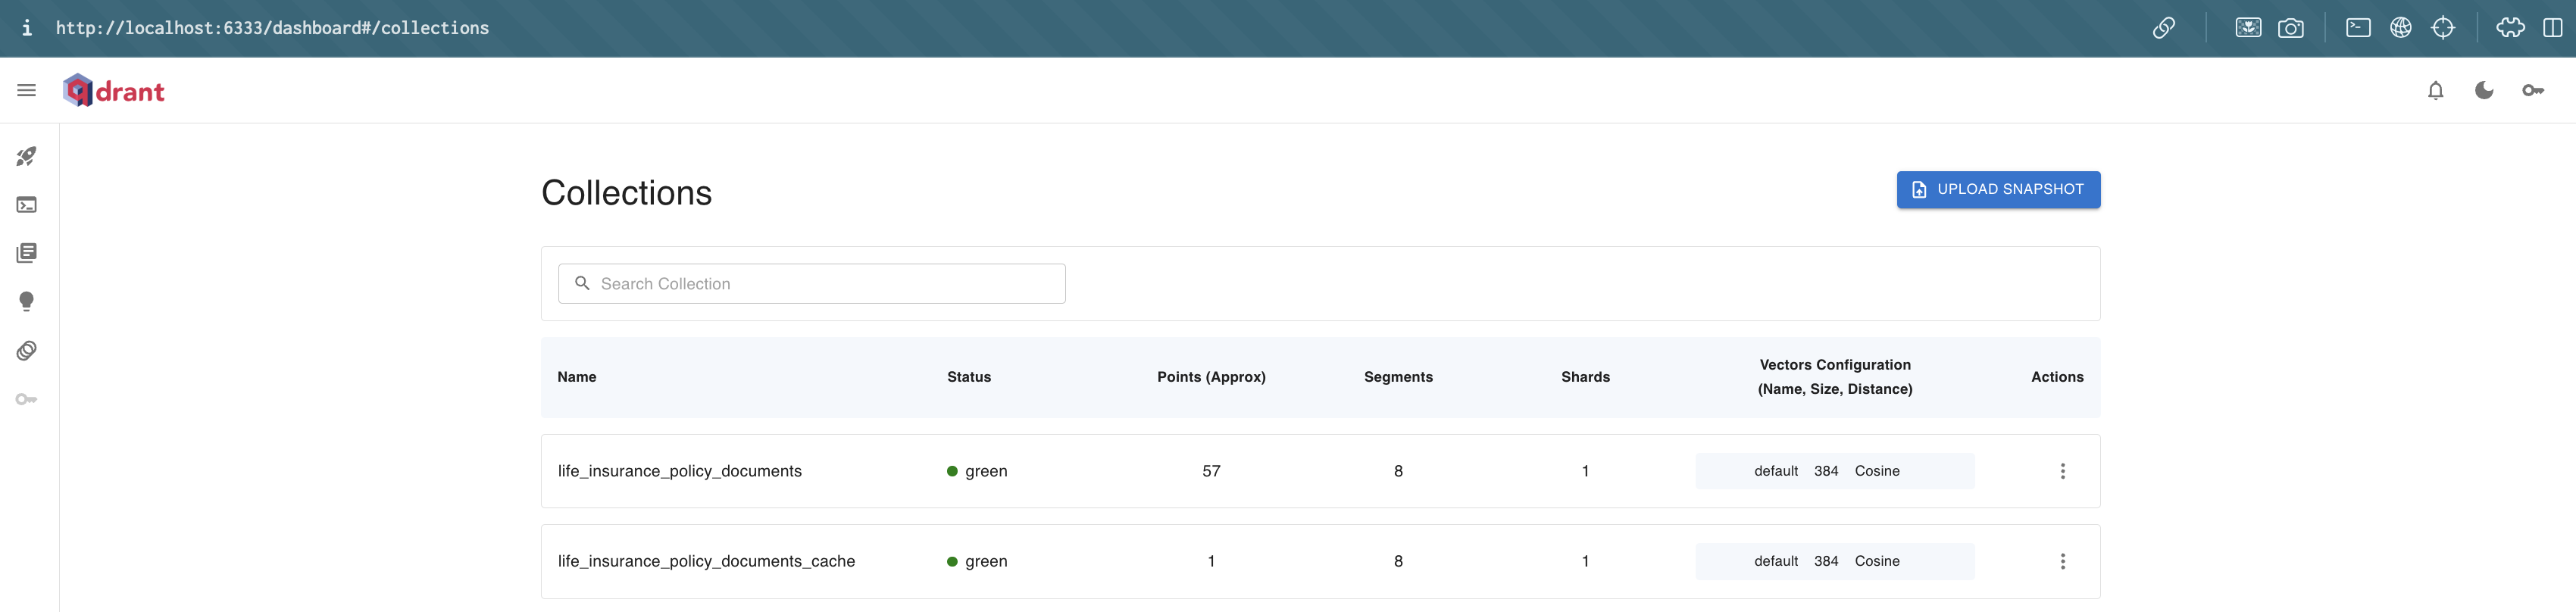

#### Re-Ranking

In [10]:
def get_df_from_points(vector_points):
    flat_items = []
    [flat_items.append({
        "id" : point["id"],
        "version": point["version"],
        "score": point["score"],
        "part": point["part"],
        "section": point["section"],
        "article": point["article"],
        "content": point["content"],
        "text_length": point["text_length"]
    }) for point in vector_points]

    return pd.DataFrame(flat_items)

def get_re_ranked_results(query, vector_points):
    re_ranking_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
    results_df = get_df_from_points(vector_points)
    results_df['re_ranking_scores'] = results_df.apply(lambda x: re_ranking_model.predict([[query, x['content']]])[0], axis = 1)
    return results_df

def search_with_re_ranking(query, limit=5):
    vector_points = search(query, limit)
    results = get_re_ranked_results(query, vector_points)
    return results[['part', 'section', 'article', 'content']]

##### re-ranking comparison with distance score

In [11]:
query = "who has the authority of changing the policy?"
vector_points = search(query)
re_ranked_results = get_re_ranked_results(query, vector_points)
similaritysearch_reranking_comparision_df = re_ranked_results.sort_values(by = ['re_ranking_scores'], ascending = False)
similaritysearch_reranking_comparision_df = similaritysearch_reranking_comparision_df[['score', 're_ranking_scores', 'id']]
similaritysearch_reranking_comparision_df

Cache miss!


,score,re_ranking_scores,id
0,0.548356,4.623034,1
2,0.427931,-5.191046,5
1,0.448610,-6.051162,9


##### observation
- re-ranking produces a different result than regular semantic search
- based on regular semantic search, the chosen top 3 chunks are 1, 9 and 2
- based on re-ranking, the chosen top 3 chunks are 1, 13 and 5

### Generation Layer

#### openai connection and initial system prompt

In [12]:
with open('../OPENAI_API_KEY.txt', 'r') as openai_key_file:
    openai.api_key = openai_key_file.readline()

def get_chat_model_completions(messages):
    response_llm = openai.chat.completions.create(
        model = 'gpt-4o-mini',
        temperature = 0,
        messages = messages
    )
    return response_llm.choices[0].message.content

def get_insurance_answers(question, relevant_context):

    delimiter = "#"*10
    
    system_prompt = f"""
        You are a helpful assistant in the insurance domain who understand the policies and documents related to the insurance domain. Specifically life insurance.
        You will help the users by answering their important questions.
        You will be given relevant context to answer the user's questions. This relevant context is created from an insurance document. The relevant context will be given to you in the format of a dataframe.
        The relevant context contains "part" which represents one of the main parts of the insurance document.
        The relevant context also contains "section" which represents one of the sections under a part in the insurance document.
        The relevant context also contains "article" which represents an article under a part and section, in the insurance document.
        The relevant context also contains "content" which belongs to a part/section/article.
        Each relevant context in the dataframe is an important piece of information. The rows in the dataframe are sorted based on their relative importance. The first document is most relevant and so on.

        {delimiter}

        Your job is to provide the answer of the question "{question}" by using the relevant context available in {relevant_context}. If you are not sure of the answer, say that you do not know.
        

        {delimiter}

        Follow these guidelines when performing the task.
        1. You don't have to necessarily use all the information in the dataframe. Use only information which is relevant.
        2. Use the "part", "section", "article" and the summary of "content" column in the dataframe for any citations.
        3. You can use your own knowledge to explain specific terms in the domain of life insurance.

        {delimiter}

        The output should follow the below guidelines:
        1. The output should contain a final answer in the manner user has asked, relevant part/section/article/content-summary in a tabular format.
        2. The output should answer the question directly addressing the user and avoid any additional information. If you think that the provided relevant context is not related to the question, mention it in the response.
        
    """
    
    messages = [
                {
                    "role": "system", "content": system_prompt
                },
                {
                    "role": "user", "content": question
                }
              ]
    return get_chat_model_completions(messages)

def user_query(query):
    search_results_df = search_with_re_ranking(query)
    search_results_df = search_results_df[:3]
    print("")
    print("---------------------- semantic search results ------------------------")
    print(json.dumps(search_results_df[['part', 'section', 'article']].to_dict(orient='records'), indent=2))
    output = get_insurance_answers(query, search_results_df)
    print("")
    print("---------------------- llm response -----------------------------------")
    print(output)
    

#### test user_query search

In [15]:
user_query("What happens to my life insurance benefit if I become terminally ill?")

Cache miss!

---------------------- semantic search results ------------------------
[
  {
    "part": "PART IV - BENEFITS",
    "section": "Section  A - Member Life Insurance",
    "article": "Article 7 - Accelerated Benefits"
  },
  {
    "part": "PART IV - BENEFITS",
    "section": "Section  C - Dependent Life Insurance",
    "article": "Article 2 - Death Benefits Payable"
  },
  {
    "part": "PART IV - BENEFITS",
    "section": "Section  A - Member Life Insurance",
    "article": "Article 2 - Death Benefits Payable"
  }
]

---------------------- llm response -----------------------------------
If you become terminally ill, you may be eligible for accelerated benefits under your life insurance policy. This means that you can receive a portion of your life insurance benefit while you are still alive, which can help cover medical expenses or other costs associated with your illness.

Here is the relevant information:

| Part                     | Section                          | Ar

## Query Search

### First Query

#### query

#### search

#### generation

### Second Query

#### query

#### search

#### generation

### Third Query

#### query

#### search

#### generation

# Conclusions

## Challenges faced